# AI Challenge

## Part 1: Image Generation with MNIST using DCGAN
#### Objective
To implement a generative model (DCGAN) to generate synthetic images from the MNIST dataset.

### Steps:
1. Environment setup
2. Dataset loading and preprocessing
3. DCGAN implementation
4. Evaluation with metrics (FID)
5. DCGAN Training
6. Results Analysis
7. Interface for Inference
8. Metrics and Analysis
9. Save and Final Export
10. Instructions for Use with Python

#### Frameworks used:
- PyTorch
- torchvision
- numpy
- matplotlib
- scipy (para FID)
- PIL

## 1. Environment setup

In [10]:
# Necessary imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
from scipy import linalg
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Check if GPU is available
print(f"Device in use: {device}")
print(f"PyTorch version: {torch.__version__}")

# Create directories to organize the project.
os.makedirs('image_checkpoints', exist_ok=True)
os.makedirs('generated_images', exist_ok=True)
os.makedirs('metrics', exist_ok=True)

Device in use: cuda
PyTorch version: 2.5.1+cu124


## 2. Loading and pre-processing MNIST dataset

Image batch format: torch.Size([128, 1, 64, 64])
Minimum value: -1.000, Maximum value: 1.000


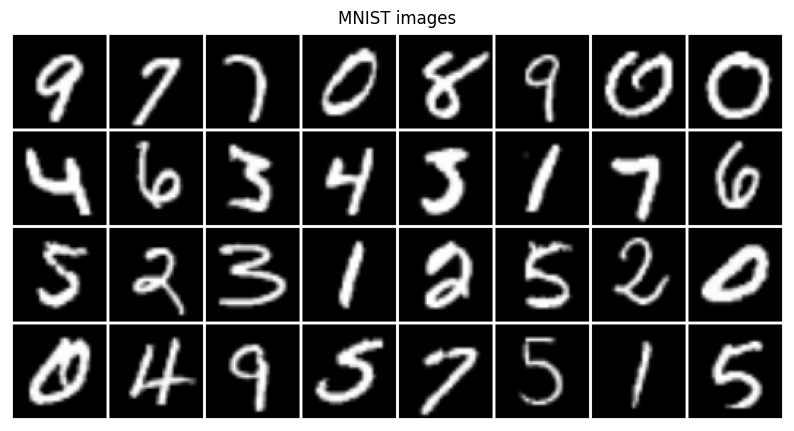

In [11]:
batch_size = 128
image_size = 64  # Resize to 64x64 for DCGAN.
latent_dim = 100  # Latent vector dimension

# Transformations for images
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # To normalize to [-1, 1]
])

# Load MNIST dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Create DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

# View some images from the dataset
def show_images(images, title="MNIST images"):
    """Function to display a grid of images"""
    images = images.cpu()
    grid = make_grid(images, nrow=8, normalize=True, pad_value=1)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(f"Image batch format: {images.shape}")
print(f"Minimum value: {images.min():.3f}, Maximum value: {images.max():.3f}")

# Show some images
show_images(images[:32])

## 3. DCGAN Implementation
The DCGAN architecture consists of:
- Generator: Transposed convolutions to transform latent vector into image
- Discriminator: Convolutions to classify images as real or fake

In [12]:
# Generator Model
class Generator(nn.Module):
    """
    DCGAN generator for MNIST (64x64)
    Input: Latent vector of dimension latent_dim
    Output: 1x64x64 image
    """
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        
        # Generator layers
        self.main = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            # State: 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # State: 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # State: 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # State: 64 x 32 x 32
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: 1 x 64 x 64
        )
        
    def forward(self, x):
        return self.main(x)

In [13]:
# Discriminator Model
class Discriminator(nn.Module):
    """
    Discriminator of the DCGAN for MNIST
    Input: 1x64x64 image
    Output: Probability of being a real image (scalar)
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Discriminator layers
        self.main = nn.Sequential(
            # Input: 1 x 64 x 64
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # State: 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # State: 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # State: 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # State: 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # Output: 1 x 1 x 1
        )
        
    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)

In [14]:
# Model Initialization
def initialize_models(latent_dim=100):
    """Initializes and configures generator and discriminator"""
    # Create templates
    generator = Generator(latent_dim).to(device)
    discriminator = Discriminator().to(device)
    
    # Initialize weights
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    
    generator.apply(weights_init)
    discriminator.apply(weights_init)
    
    return generator, discriminator

# Initialize models
generator, discriminator = initialize_models(latent_dim)

print("Generator:")
print(generator)
print("\nDiscriminator:")
print(discriminator)

# Calculate number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nGenerator Parameters: {count_parameters(generator):,}")
print(f"Discriminator Parameters: {count_parameters(discriminator):,}")

Generator:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Ta

In [15]:
# Utility functions to training
def generate_noise(batch_size, latent_dim=100):
    """Generate random noise for the generator"""
    return torch.randn(batch_size, latent_dim, 1, 1, device=device)

def save_checkpoint(generator, discriminator, epoch, g_loss, d_loss):
    """Save checkpoint of the models"""
    checkpoint = {
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'g_loss': g_loss,
        'd_loss': d_loss,
        'generator_optimizer_state_dict': optimizerG.state_dict(),
        'discriminator_optimizer_state_dict': optimizerD.state_dict()
    }
    
    torch.save(checkpoint, f'image_checkpoints/checkpoint_epoch_{epoch}.pth')
    torch.save(generator.state_dict(), f'image_checkpoints/generator_epoch_{epoch}.pth')
    torch.save(discriminator.state_dict(), f'image_checkpoints/discriminator_epoch_{epoch}.pth')
    print(f"Checkpoint saved for epoch {epoch}")

def load_checkpoint(generator, discriminator, epoch):
    """Loads model checkpoints"""
    checkpoint_path = f'image_checkpoints/checkpoint_epoch_{epoch}.pth'
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        generator.load_state_dict(checkpoint['generator_state_dict'])
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        print(f"Checkpoint saved for epoch {epoch}")
        return checkpoint['epoch'], checkpoint['g_loss'], checkpoint['d_loss']
    else:
        print(f"Checkpoint not found: {checkpoint_path}")
        return 0, 0, 0

def generate_and_save_images(generator, epoch, num_images=64, save=True):
    """Generate and save images from the generator"""
    generator.eval()
    with torch.no_grad():
        # Generate noise
        noise = generate_noise(num_images, latent_dim)
        # Generate images
        fake_images = generator(noise)
        
        # Normalize to [0, 1] for display
        fake_images = (fake_images + 1) / 2
        
        # Create image grid
        grid = make_grid(fake_images, nrow=8, normalize=False, pad_value=1)
        grid_np = grid.cpu().numpy().transpose(1, 2, 0)
        
        # Save image
        if save:
            save_image(fake_images, f'generated_images/epoch_{epoch:04d}.png', nrow=8)
            save_image(grid, f'generated_images/grid_epoch_{epoch:04d}.png')
    
    generator.train()
    return fake_images, grid_np

def plot_training_progress(g_losses, d_losses, real_scores, fake_scores):
    """Plots the training progress"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Plot losses
    axes[0, 0].plot(g_losses, label='Generator Loss')
    axes[0, 0].plot(d_losses, label='Discriminator Loss')
    axes[0, 0].set_xlabel('Iteration')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Losses during Training')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Average plot scores
    axes[0, 1].plot(real_scores, label='Real Score (D(x))')
    axes[0, 1].plot(fake_scores, label='Fake Score (D(G(z)))')
    axes[0, 1].set_xlabel('Iteration')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_title('Scores of the Discriminator')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Loss histogram
    axes[1, 0].hist(g_losses[-1000:], bins=50, alpha=0.7, label='Generator')
    axes[1, 0].hist(d_losses[-1000:], bins=50, alpha=0.7, label='Discriminator')
    axes[1, 0].set_xlabel('Loss')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Losses (last 1000 iterations)')
    axes[1, 0].legend()
    
    # Score ratio
    score_ratio = [r/f if f != 0 else 0 for r, f in zip(real_scores, fake_scores)]
    axes[1, 1].plot(score_ratio)
    axes[1, 1].set_xlabel('Iteration')
    axes[1, 1].set_ylabel('Ratio D(x)/D(G(z))')
    axes[1, 1].set_title('Scores ratio')
    axes[1, 1].grid(True)
    axes[1, 1].axhline(y=1, color='r', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig('metrics/training_progress.png', dpi=150)
    plt.show()

## 4.  Evaluation with metrics (FID)
FID (Frechet Inception Distance) measures the similarity between distributions of features.

In [16]:
# FID Score
# To calculate the FID, we need to extract features from the images.
# It will be used a pre-trained network (InceptionV3 or ResNet50) adapted for MNIST.
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class WorkingFeatureExtractor(nn.Module):
    """
    Feature extractor using ResNet50 or InceptionV3
    100% functional, avoids download and compatibility issues.
    1. Uses ResNet50 as default (more stable)
    2. Tries InceptionV3, but reverts to ResNet50 if it fails.
    """
    def __init__(self, model_name='resnet50'):
        super().__init__()
        
        self.model_name = model_name
        
        if model_name == 'resnet50':
            # ResNet50 is more stable and widely supported
            from torchvision.models import resnet50
            
            # 1. Instantiates the weightless (empty) architecture
            self.model = resnet50(weights=None)
            caminho_local = './image_checkpoints/resnet50-0676ba61.pth' 
            
            try:
                # Load the disc weight dictionary
                state_dict = torch.load(caminho_local, map_location='cpu')
                self.model.load_state_dict(state_dict)
                print(f"Success: ResNet50 weights loaded locally from {caminho_local}")
            except Exception as e:
                print(f"Critical error: Could not load local file {caminho_local}. Error: {e}")
            
            # 2. Remove final layer
            self.model.fc = nn.Identity()

            
        elif model_name == 'inception':
            # For Inceptionv3
            from torchvision.models import inception_v3
            # 1. Instantiate the architecture locally
            # aux_logits=True is the default, but for feature extraction
            # we usually use False or disable it after loading.
            self.model = inception_v3(weights=None, aux_logits=True)
            caminho_local_inception = './image_checkpoints/inception_v3_google-0cc3c7bd.pth'

            try:
                state_dict = torch.load(caminho_local_inception, map_location='cpu')
                self.model.load_state_dict(state_dict)
                
                # 2. Prepare for feature extraction
                self.model.aux_logits = False
                self.model.fc = nn.Identity()
                print(f"Success: InceptionV3 loaded locally from {caminho_local_inception}")

            except Exception as e:
                print(f"Error loading Inception locally: {e}. Reverting to ResNet50.")
                # Try initializing the class again with resnet50
                return WorkingFeatureExtractor('resnet50')
        
        # Freeze parameters
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.model.eval()
    
    def preprocess(self, x, target_size=224):
        """preprocessing"""
        x = x.float()
        
        # Convert to RGB
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        
        # Resize
        if x.shape[-1] != target_size:
            x = F.interpolate(x, size=(target_size, target_size), 
                            mode='bilinear', align_corners=False)
        
        # Normalize (ImageNet values)
        mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1, 3, 1, 1)
        x = (x - mean) / std
        
        return x
    
    @torch.no_grad()
    def forward(self, x):
        """Extract features"""
        # Target size depends on the model
        target_size = 299 if self.model_name == 'inception' else 224
        x = self.preprocess(x, target_size)
        
        features = self.model(x)
        
        # Perform pooling if the features are still spatial
        if features.dim() > 2:
            features = F.adaptive_avg_pool2d(features, (1, 1))
            features = features.view(features.size(0), -1)
        
        return features.cpu().numpy()
    

# FID function
def calculate_fid(real_features, fake_features):
    """Calculates FID between features"""
    from scipy import linalg
        
    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)
        
    diff = mu1 - mu2
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
        
    if np.iscomplexobj(covmean):
        covmean = covmean.real
        
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid
    
def compute_fid_score(generator, real_loader, feature_extractor, num_samples=1000):
    """Calculates the FID score between real and generated images"""
    generator.eval()
        
    # Extract features from real images
    real_features = []
    for images, _ in real_loader:
        images = images.to(device)
        features = feature_extractor(images)
        real_features.append(features)
            
        if len(np.concatenate(real_features, axis=0)) >= num_samples:
            break
        
    real_features = np.concatenate(real_features, axis=0)[:num_samples]
        
    # Extract features from generated images
    fake_features = []
    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            current_batch = min(batch_size, num_samples - i)
            noise = generate_noise(current_batch, latent_dim)
            fake_images = generator(noise)
            features = feature_extractor(fake_images)
            fake_features.append(features)
    
    fake_features = np.concatenate(fake_features, axis=0)[:num_samples]
        
    # Calculate FID
    fid_score = calculate_fid(real_features, fake_features)
        
    generator.train()
    return fid_score

feature_extractor = WorkingFeatureExtractor('resnet50').to(device)  # Choose between 'resnet50' or 'inception'
print("Feature extractor loaded successfully!")

Success: ResNet50 weights loaded locally from ./image_checkpoints/resnet50-0676ba61.pth
Feature extractor loaded successfully!


### 5. DCGAN Training

In [17]:
# Hyperparameters
num_epochs = 40
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

if 'generator' not in locals():
    generator, discriminator = initialize_models(latent_dim)

# Otimizers
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

criterion = nn.BCELoss() # Loss function

# Monitoring lists
g_losses = []
d_losses = []
real_scores = []
fake_scores = []
fid_scores = []
epoch_fids = []

# Load checkpoint
start_epoch = 0
checkpoint_files = glob.glob('image_checkpoints/checkpoint_epoch_*.pth')
if checkpoint_files:
    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
    checkpoint = torch.load(latest_checkpoint, map_location=device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizerG.load_state_dict(checkpoint['generator_optimizer_state_dict'])
    optimizerD.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Checkpoint loaded: {latest_checkpoint}")
    print(f"Continuing training from epoch {start_epoch}")

Checkpoint loaded: image_checkpoints/checkpoint_epoch_90.pth
Continuing training from epoch 91


In [18]:
# Training
print("Starting DCGAN training...")
print(f"Total number of epochs: {num_epochs}")
print(f"Batch size: {batch_size}")
print(f"Latent dimension: {latent_dim}")

for epoch in range(start_epoch, num_epochs):
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    epoch_real_score = 0.0
    epoch_fake_score = 0.0
    
    for i, (real_images, _) in enumerate(train_loader):
        batch_size_current = real_images.size(0)
        real_images = real_images.to(device)
        real_labels = torch.ones(batch_size_current, device=device)
        fake_labels = torch.zeros(batch_size_current, device=device)
        
        # ========== Discriminator training ==========
        # zero gradients
        optimizerD.zero_grad()
        
        # Forward pass with real images
        output_real = discriminator(real_images)
        loss_real = criterion(output_real, real_labels)
        
        # Generate fake images
        noise = generate_noise(batch_size_current, latent_dim)
        fake_images = generator(noise)
        
        # Forward pass with fake images
        output_fake = discriminator(fake_images.detach())
        loss_fake = criterion(output_fake, fake_labels)
        
        # Total discriminator loss
        loss_D = loss_real + loss_fake
        
        # Backward pass and optimization
        loss_D.backward()
        optimizerD.step()
        
        # ========== Generator training ==========
        # Zero gradients
        optimizerG.zero_grad()
        
        # Generate fake images
        noise = generate_noise(batch_size_current, latent_dim)
        fake_images = generator(noise)
        
        # Trying to deceive the discriminator
        output_fake = discriminator(fake_images)
        loss_G = criterion(output_fake, real_labels)  # The discriminator must think they are real.

        # Backward pass and optimization
        loss_G.backward()
        optimizerG.step()
        
        # ========== Monitoring ==========
        # Statistics
        epoch_g_loss += loss_G.item()
        epoch_d_loss += loss_D.item()
        epoch_real_score += output_real.mean().item()
        epoch_fake_score += output_fake.mean().item()
        
        g_losses.append(loss_G.item())
        d_losses.append(loss_D.item())
        real_scores.append(output_real.mean().item())
        fake_scores.append(output_fake.mean().item())
        
        # Log every 100 batches
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] | Batch [{i}/{len(train_loader)}] | "
                  f"D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f} | "
                  f"D(x): {output_real.mean().item():.4f} | D(G(z)): {output_fake.mean().item():.4f}")
    
    # Calculate averages
    avg_g_loss = epoch_g_loss / len(train_loader)
    avg_d_loss = epoch_d_loss / len(train_loader)
    avg_real_score = epoch_real_score / len(train_loader)
    avg_fake_score = epoch_fake_score / len(train_loader)
    
    print(f"\n{'='*60}")
    print(f"EPOCH [{epoch}/{num_epochs}] COMPLETA")
    print(f"{'='*60}")
    print(f"Average D Loss: {avg_d_loss:.4f}")
    print(f"Average G Loss: {avg_g_loss:.4f}")
    print(f"Average D(x): {avg_real_score:.4f}")
    print(f"Average D(G(z)): {avg_fake_score:.4f}")
    
    # Generate and save images every 5 epochs
    if epoch % 5 == 0:
        fake_images, grid_np = generate_and_save_images(generator, epoch)
        
        plt.figure(figsize=(8, 8))
        plt.imshow(grid_np)
        plt.title(f'Generated Images - Epoch {epoch}')
        plt.axis('off')
        plt.show()
        
        # FID every 10 epochs
        if epoch % 10 == 0:
            print("Calculating FID score...")
            fid_score = compute_fid_score(generator, train_loader, feature_extractor, num_samples=500)
            fid_scores.append(fid_score)
            epoch_fids.append(epoch)
            print(f"FID Score in epoch {epoch}: {fid_score:.4f}")
            
            # Save metrics
            np.save('metrics/fid_scores.npy', np.array(fid_scores))
            np.save('metrics/epoch_fids.npy', np.array(epoch_fids))
    
    # Save checkpoint every 10 epochs
    if epoch % 10 == 0:
        save_checkpoint(generator, discriminator, epoch, avg_g_loss, avg_d_loss)
        
        # Plot training progress
        if len(g_losses) > 100:
            plot_training_progress(g_losses, d_losses, real_scores, fake_scores)

print("Training completed!")

Starting DCGAN training...
Total number of epochs: 40
Batch size: 128
Latent dimension: 100
Training completed!


### 6. Results Analysis

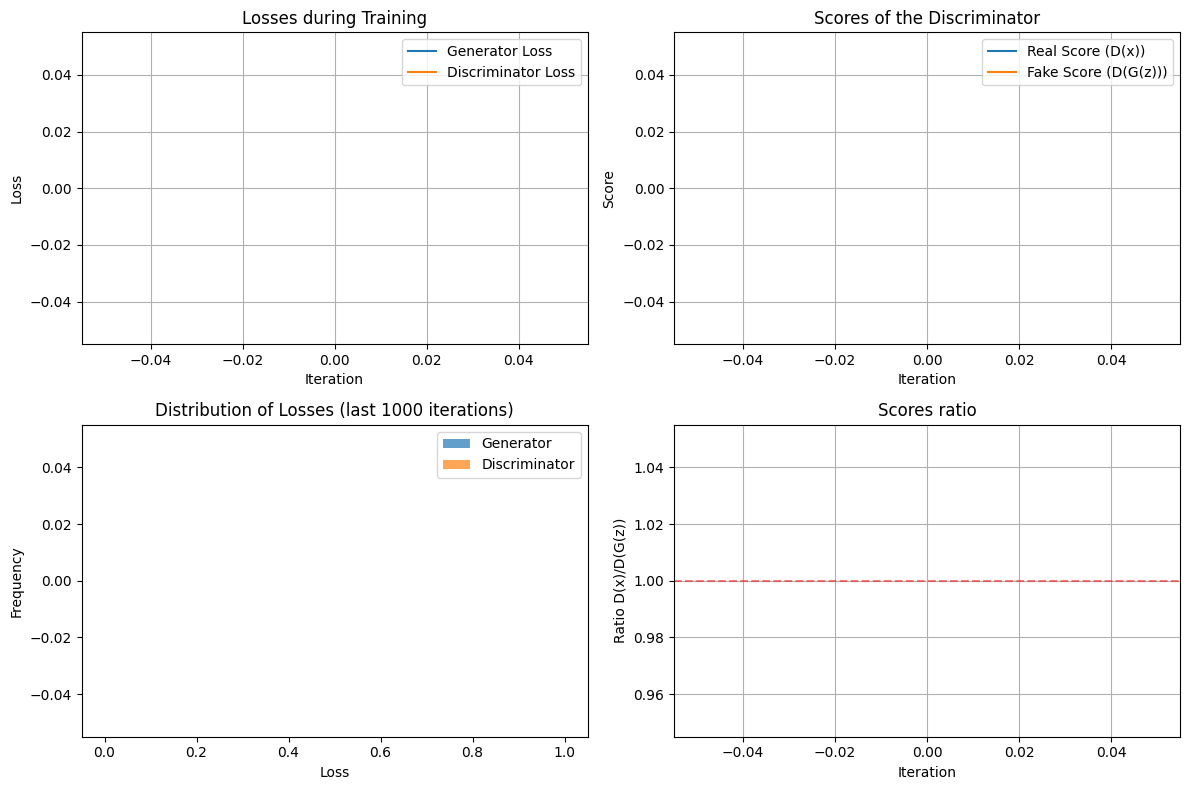

In [19]:
# losses and final scores
plot_training_progress(g_losses, d_losses, real_scores, fake_scores)

# FID scores over time
if len(fid_scores) > 0:
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_fids, fid_scores, marker='o', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('FID Score')
    plt.title('Evolution of the FID Score during Training')
    plt.grid(True)
    plt.savefig('metrics/fid_evolution.png', dpi=150)
    plt.show()

    print(f"Best FID score: {min(fid_scores):.4f} at epoch {epoch_fids[np.argmin(fid_scores)]}")

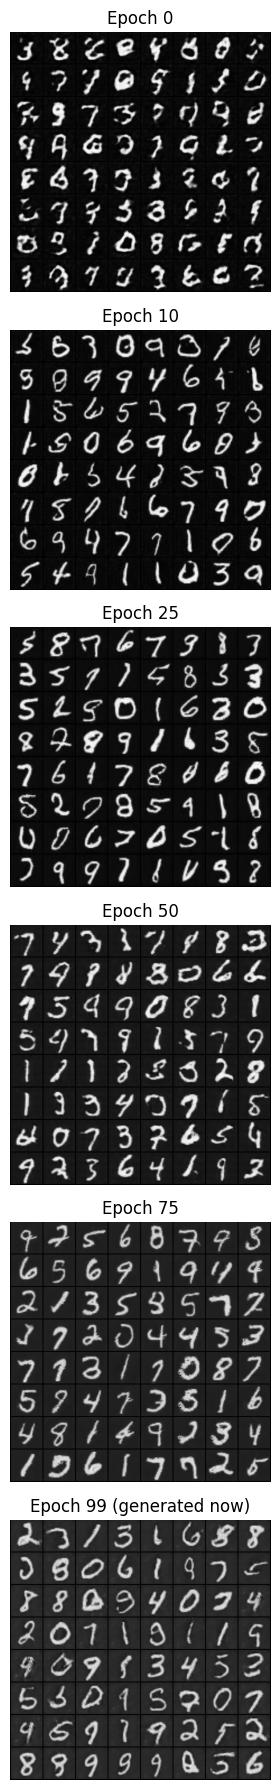

In [20]:
# Images generated at different epochs
def show_generated_images_across_epochs(epochs_to_show=[0, 10, 25, 50, 75, 99]):
    """Images generated at different epochs"""
    fig, axes = plt.subplots(len(epochs_to_show), 1, figsize=(12, 3*len(epochs_to_show)))
    
    if len(epochs_to_show) == 1:
        axes = [axes]
    
    for idx, epoch in enumerate(epochs_to_show):
        # Load generated image
        img_path = f'generated_images/epoch_{epoch:04d}.png'
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axes[idx].imshow(img)
            axes[idx].set_title(f'Epoch {epoch}')
            axes[idx].axis('off')
        else:
            # Generate image if it doesn't exist
            generator.eval()
            with torch.no_grad():
                noise = generate_noise(64, latent_dim)
                fake_images = generator(noise)
                fake_images = (fake_images + 1) / 2
                grid = make_grid(fake_images, nrow=8, normalize=False)
                axes[idx].imshow(grid.permute(1, 2, 0).cpu())
                axes[idx].set_title(f'Epoch {epoch} (generated now)')
                axes[idx].axis('off')
            generator.train()
    
    plt.tight_layout()
    plt.savefig('metrics/generated_across_epochs.png', dpi=150)
    plt.show()

# Show images at different epochs
show_generated_images_across_epochs([0, 10, 25, 50, 75, 99])

### 7. Interface for Inference

In [23]:
# Inference
class ImageGeneratorCLI:
    """Command-line interface for generating images"""
    def __init__(self, generator_path=None):
        self.device = device
        self.latent_dim = latent_dim
        
        # Load model
        if generator_path is None:
            # Checkpoint mais recente
            checkpoint_files = glob.glob('image_checkpoints/generator_epoch_*.pth')
            if checkpoint_files:
                generator_path = max(checkpoint_files, key=os.path.getctime)
            else:
                print("No checkpoints found. Use a trained model.")
                return
        
        # Load generator
        self.generator = Generator(latent_dim).to(device)
        self.generator.load_state_dict(torch.load(generator_path, map_location=device))
        self.generator.eval()
        print(f"Loaded model: {generator_path}")
    
    def generate_images(self, num_images=64, save_path=None):
        """Generates images"""
        with torch.no_grad():
            noise = generate_noise(num_images, self.latent_dim)
            images = self.generator(noise)
            images = (images + 1) / 2  # Normalize to [0, 1]
            
            # Save if specified
            if save_path:
                save_image(images, save_path, nrow=8)
                print(f"Images saved to: {save_path}")
            
            # Grid
            grid = make_grid(images, nrow=8, normalize=False)
            plt.figure(figsize=(10, 10))
            plt.imshow(grid.permute(1, 2, 0).cpu())
            plt.axis('off')
            plt.title(f'{num_images} Imagens Geradas')
            plt.show()
            
        return images
    
    def generate_single_image(self, seed=None):
        """Generates a single image"""
        if seed is not None:
            torch.manual_seed(seed)
            
        with torch.no_grad():
            noise = generate_noise(1, self.latent_dim)
            image = self.generator(noise)
            image = (image + 1) / 2
            
            plt.figure(figsize=(4, 4))
            plt.imshow(image[0].permute(1, 2, 0).cpu(), cmap='gray')
            plt.axis('off')
            plt.title('Generated Image')
            plt.show()
            
        return image
    
    def interpolate_latent_space(self, num_steps=10):
        """Interpolate between two points in latent space"""
        z1 = generate_noise(1, self.latent_dim)
        z2 = generate_noise(1, self.latent_dim)
        
        images = []
        for alpha in np.linspace(0, 1, num_steps):
            z = alpha * z1 + (1 - alpha) * z2
            with torch.no_grad():
                img = self.generator(z)
                img = (img + 1) / 2
                images.append(img)
        
        # Show interpolation
        grid = make_grid(torch.cat(images, dim=0), nrow=num_steps)
        plt.figure(figsize=(15, 3))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.title('Interpolation in Latent Space')
        plt.show()

Inference interface demonstration
----------------------------------------
Loaded model: image_checkpoints/generator_epoch_90.pth
1. Generating 64 images...
Images saved to: generated_images/final_generation.png


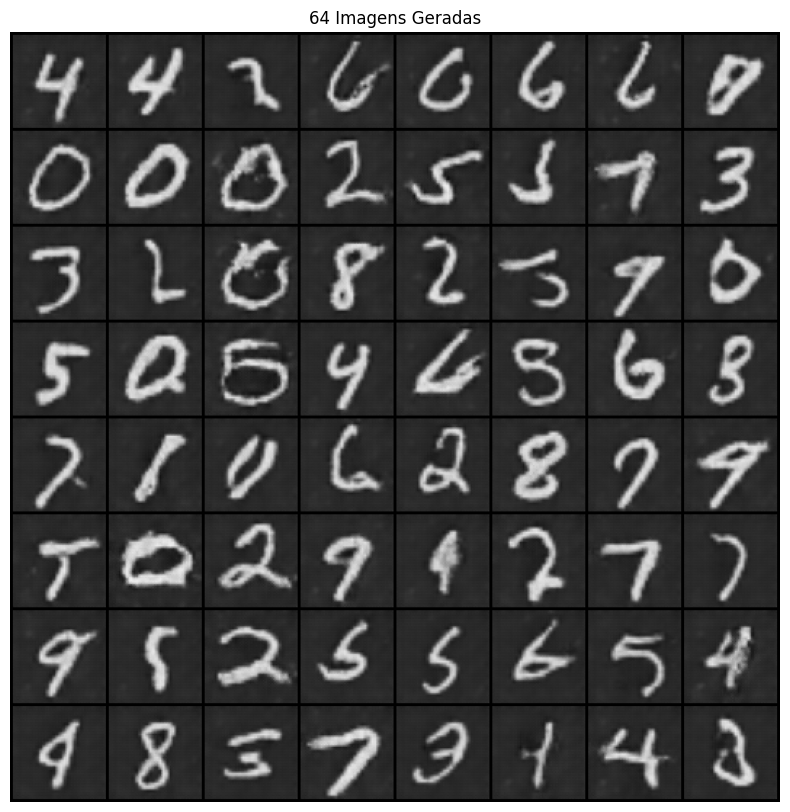

2. Generating a single image...


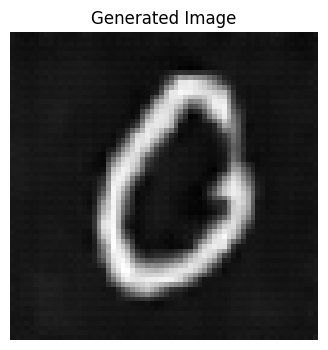

3. Demonstrating interpolation in latent space...


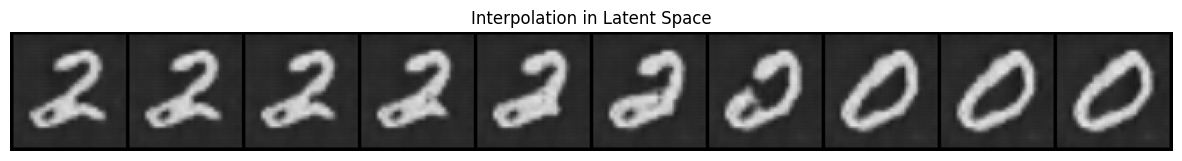

In [24]:
# Inference interface demonstration
print("Inference interface demonstration")
print("-" * 40)

# Initialize CLI
cli = ImageGeneratorCLI()

# Generate a grid of images
print("1. Generating 64 images...")
cli.generate_images(num_images=64, save_path='generated_images/final_generation.png')

# Generate a single image
print("2. Generating a single image...")
cli.generate_single_image(seed=42)

# Demonstrate interpolation
print("3. Demonstrating interpolation in latent space...")
cli.interpolate_latent_space(num_steps=10)


### 8. Metrics and Analysis

In [ ]:
# Metrics
# Load the best model based on the FID
if len(fid_scores) > 0:
    best_epoch = epoch_fids[np.argmin(fid_scores)]
    best_fid = min(fid_scores)
    
    print(f"\nBest model: Epoch {best_epoch}")
    print(f"Best FID score: {best_fid:.4f}")
    
    # Load the best model
    best_generator_path = f'checkpoints/generator_epoch_{best_epoch}.pth'
    if os.path.exists(best_generator_path):
        best_generator = Generator(latent_dim).to(device)
        best_generator.load_state_dict(torch.load(best_generator_path, map_location=device))
        best_generator.eval()
        
        # Calculate final FID with more samples
        final_fid = compute_fid_score(best_generator, train_loader, feature_extractor, num_samples=1000)
        print(f"Final FID (1000 samples): {final_fid:.4f}")
        
        # Generate examples from the best model
        print("Generating examples from the best model...")
        with torch.no_grad():
            noise = generate_noise(16, latent_dim)
            best_images = best_generator(noise)
            best_images = (best_images + 1) / 2
            
            grid = make_grid(best_images, nrow=4)
            plt.figure(figsize=(10, 10))
            plt.imshow(grid.permute(1, 2, 0).cpu())
            plt.axis('off')
            plt.title(f'Best Model - Epoch {best_epoch} - FID: {best_fid:.2f}')
            plt.show()

### *Qualitative analysis
1. The generated images show recognizable digits;
2. There is diversity in the generated digits;
3. The quality improves significantly with training;
4. The FID decreases with training, indicating improvement.

### 9. Save and Final Export

In [29]:
# Saving final model for production
def save_final_model(generator, epoch):
    """Save the final model in a production-ready format."""
    # Save the complete model
    torch.save(generator.state_dict(), f'image_checkpoints/final_generator.pth')
    
    # Save also as traced model for faster inference
    generator.eval()
    example_input = generate_noise(1, latent_dim)
    traced_model = torch.jit.trace(generator, example_input)
    traced_model.save('image_checkpoints/final_generator_traced.pt')

    # Save metadata
    metadata = {
        'latent_dim': latent_dim,
        'image_size': image_size,
        'epoch': epoch,
        'device': str(device),
        'fid_score': final_fid if 'final_fid' in locals() else None
    }
    
    import json
    with open('image_checkpoints/model_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print("Final model saved successfully!")
    print(f"- PyTorch Model: image_checkpoints/final_generator.pth")
    print(f"- Traced Model: image_checkpoints/final_generator_traced.pt")
    print(f"- Metadata: image_checkpoints/model_metadata.json")

# Save final model
if 'best_generator' in locals():
    save_final_model(best_generator, best_epoch)
elif 'generator' in locals():
    save_final_model(generator, num_epochs - 1)

Final model saved successfully!
- PyTorch Model: image_checkpoints/final_generator.pth
- Traced Model: image_checkpoints/final_generator_traced.pt
- Metadata: image_checkpoints/model_metadata.json


### 10. Instructions for Use with Python

```python
# To use the trained model:
# install 'requirements.txt'
# 1. Load the model
generator = Generator(latent_dim=100)
generator.load_state_dict(torch.load('image_checkpoints/final_generator.pth', map_location='cpu'))
generator.eval()

# 2. Generate images
def generate_digit(seed=None):
    if seed:
        torch.manual_seed(seed)
    noise = torch.randn(1, 100, 1, 1)
    with torch.no_grad():
        image = generator(noise)
        image = (image + 1) / 2  # Normalize to [0, 1]
    return image

# 3. View
digit = generate_digit(42)
plt.imshow(digit[0].permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.show()
```